In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline
import math
from IPython.display import display
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.datasets import make_imbalance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version',sns.__version__)

Numpy version 1.21.6
Pandas version 1.3.5
Seaborn version 0.11.2


In [ ]:
# Customer churn prediction for South Asian Telecom Operator
df_churn = pd.read_csv('South Asian Wireless Telecom Operator (SATO 2015).csv')

In [ ]:
# to display all columns in the dataset
pd.options.display.max_columns = None

In [ ]:
# Function to detect missing values and duplicate records

def missing_duplicates(col):
    if col.isnull().sum().sum() == 0:
        print('There are no missing values in the dataset')
    else:
        print('There are missing values in the dataset')
        
    count = 0
    for count in col.columns:
        if col[count].isnull().sum() != 0:
            print('There are {} missing values in the feature: '.format(col[count].isnull().sum()),count)
            print('Percentage of missing values in the feature:',round(col[count].isnull().sum()/col.shape[0] * 100,3),'%')
            print('Percentage of missing values in total data points:',round(col[count].isnull().sum()/(col.shape[0]*col.shape[1]) * 100,3),'%')
            
    if col.duplicated().sum() == 0:
        print('There are no duplicate records found in the dataset')
    else:
        print('There are duplicate rows found in the dataset.','\nTotal duplicate rows:', col.duplicated.sum())

In [ ]:
# Function to check balance of the target variable and countplot
def balance_ratio(col):
    print('Balance ratio of variable in Percentage')
    print(round(col.value_counts(normalize=True) * 100,2))
    print('')
    sns.countplot(col)
    plt.title('Count plot')
    plt.show()

In [ ]:
# Fuctions to plot the graphs for countplot, histograms and boxplot

# Function to plot the graph of countplots
def countplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(include=['object'])
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype == 'object':
            plt.subplot(a,b,c)
            sns.countplot(x=col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of Histograms
def histogram(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.distplot(col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of boxplots
def boxplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.boxplot(col[i])
            c = c + 1
    plt.show()
    return

# Churn Prediction dataset

In [ ]:
# checking top 5 rows of the data
df_churn.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,aug_user_type,sep_user_type,aug_fav_a,sep_fav_a,Class
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,2G,2G,telenor,mobilink,Churned
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,2G,2G,mobilink,ufone,Churned
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Other,Other,ptcl,telenor,Churned
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,2G,2G,telenor,ufone,Active
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,NaN,NaN,mobilink,ufone,Active


In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   network_age                2000 non-null   int64  
 1   Aggregate_Total_Rev        2000 non-null   float64
 2   Aggregate_SMS_Rev          2000 non-null   float64
 3   Aggregate_Data_Rev         2000 non-null   float64
 4   Aggregate_Data_Vol         2000 non-null   float64
 5   Aggregate_Calls            2000 non-null   int64  
 6   Aggregate_ONNET_REV        2000 non-null   int64  
 7   Aggregate_OFFNET_REV       2000 non-null   int64  
 8   Aggregate_complaint_count  2000 non-null   int64  
 9   aug_user_type              1755 non-null   object 
 10  sep_user_type              1794 non-null   object 
 11  aug_fav_a                  1999 non-null   object 
 12  sep_fav_a                  1999 non-null   object 
 13  Class                      2000 non-null   objec

In [ ]:
# describing the data
df_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
network_age,2000.0,1.469554e+03,1.286753e+03,-8.0000,323.500000,1194.50000,2247.250,5.451000e+03
Aggregate_Total_Rev,2000.0,9.050201e+02,1.151309e+03,4.9100,247.149600,606.57500,1220.045,2.443883e+04
Aggregate_SMS_Rev,2000.0,3.110861e+01,5.790842e+01,0.0000,3.500000,14.81000,34.140,8.739800e+02
Aggregate_Data_Rev,2000.0,5.880608e+01,2.474593e+02,0.0000,1.250000,13.75000,53.750,8.295000e+03
Aggregate_Data_Vol,2000.0,2.773961e+06,8.845272e+06,0.0586,2675.567425,182286.42965,1544504.866,1.550312e+08
Aggregate_Calls,2000.0,2.409105e+02,3.699223e+02,1.0000,25.000000,99.00000,331.250,5.727000e+03
Aggregate_ONNET_REV,2000.0,7.411284e+03,1.649439e+04,0.0000,114.000000,1940.50000,7941.000,3.811740e+05
Aggregate_OFFNET_REV,2000.0,1.645758e+04,3.431197e+04,0.0000,1432.000000,5039.00000,15790.000,4.314400e+05
Aggregate_complaint_count,2000.0,1.924500e+00,2.265693e+00,1.0000,1.000000,1.00000,2.000,4.900000e+01


Balance ratio of variable in Percentage
Churned    50.0
Active     50.0
Name: Class, dtype: float64



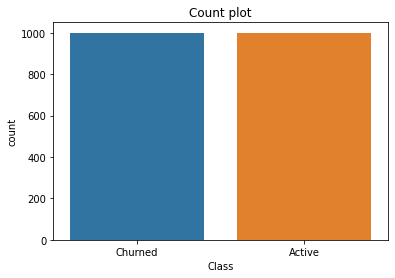

In [ ]:
balance_ratio(df_churn['Class'])

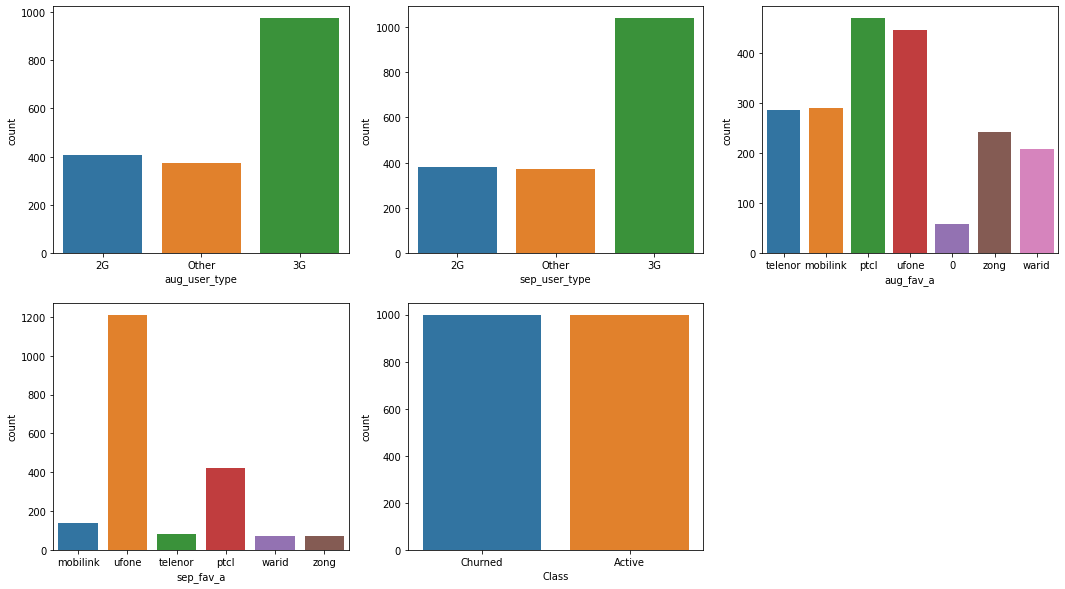

In [ ]:
# we will check countplots for categorical variables
countplots(df_churn,18,10,3)

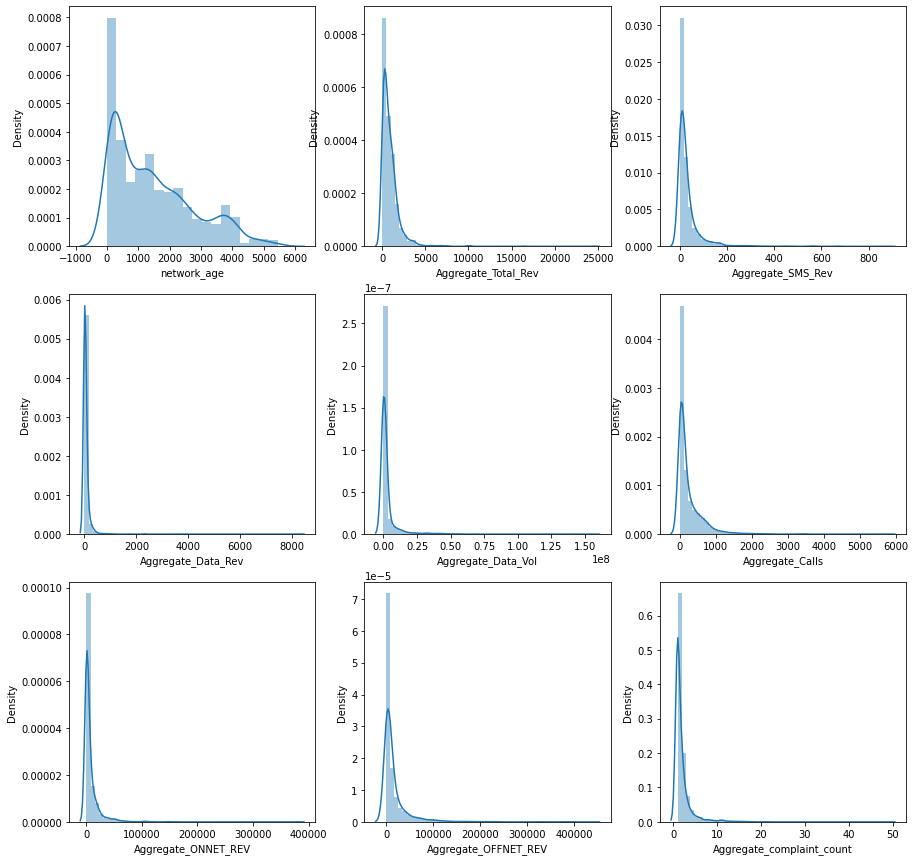

In [ ]:
histogram(df_churn,15,15,3)

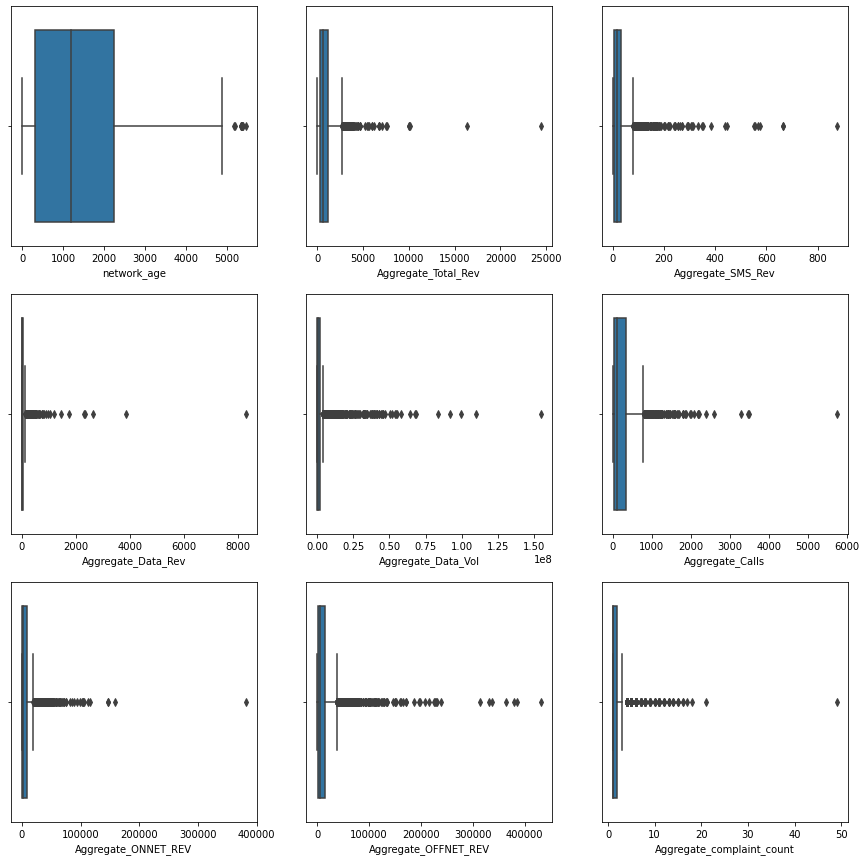

In [ ]:
boxplots(df_churn,15,15,3)

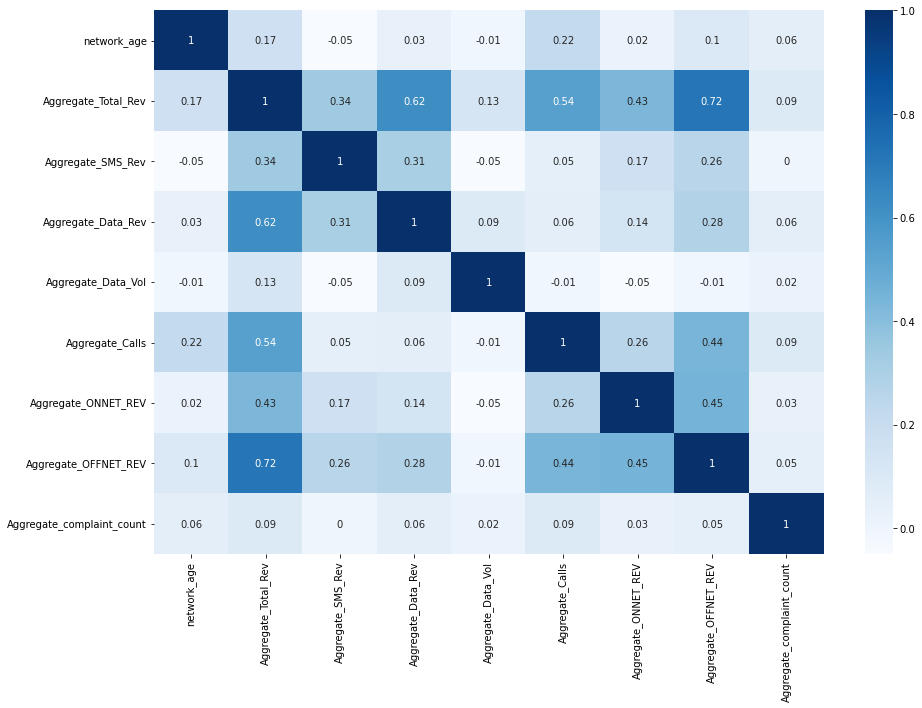

In [ ]:
#Bivariate Analysis using heatmap
plt.figure(figsize=(15,10))
sns.heatmap(round(df_churn.corr(),2),annot=True,cmap='Blues')
plt.show()

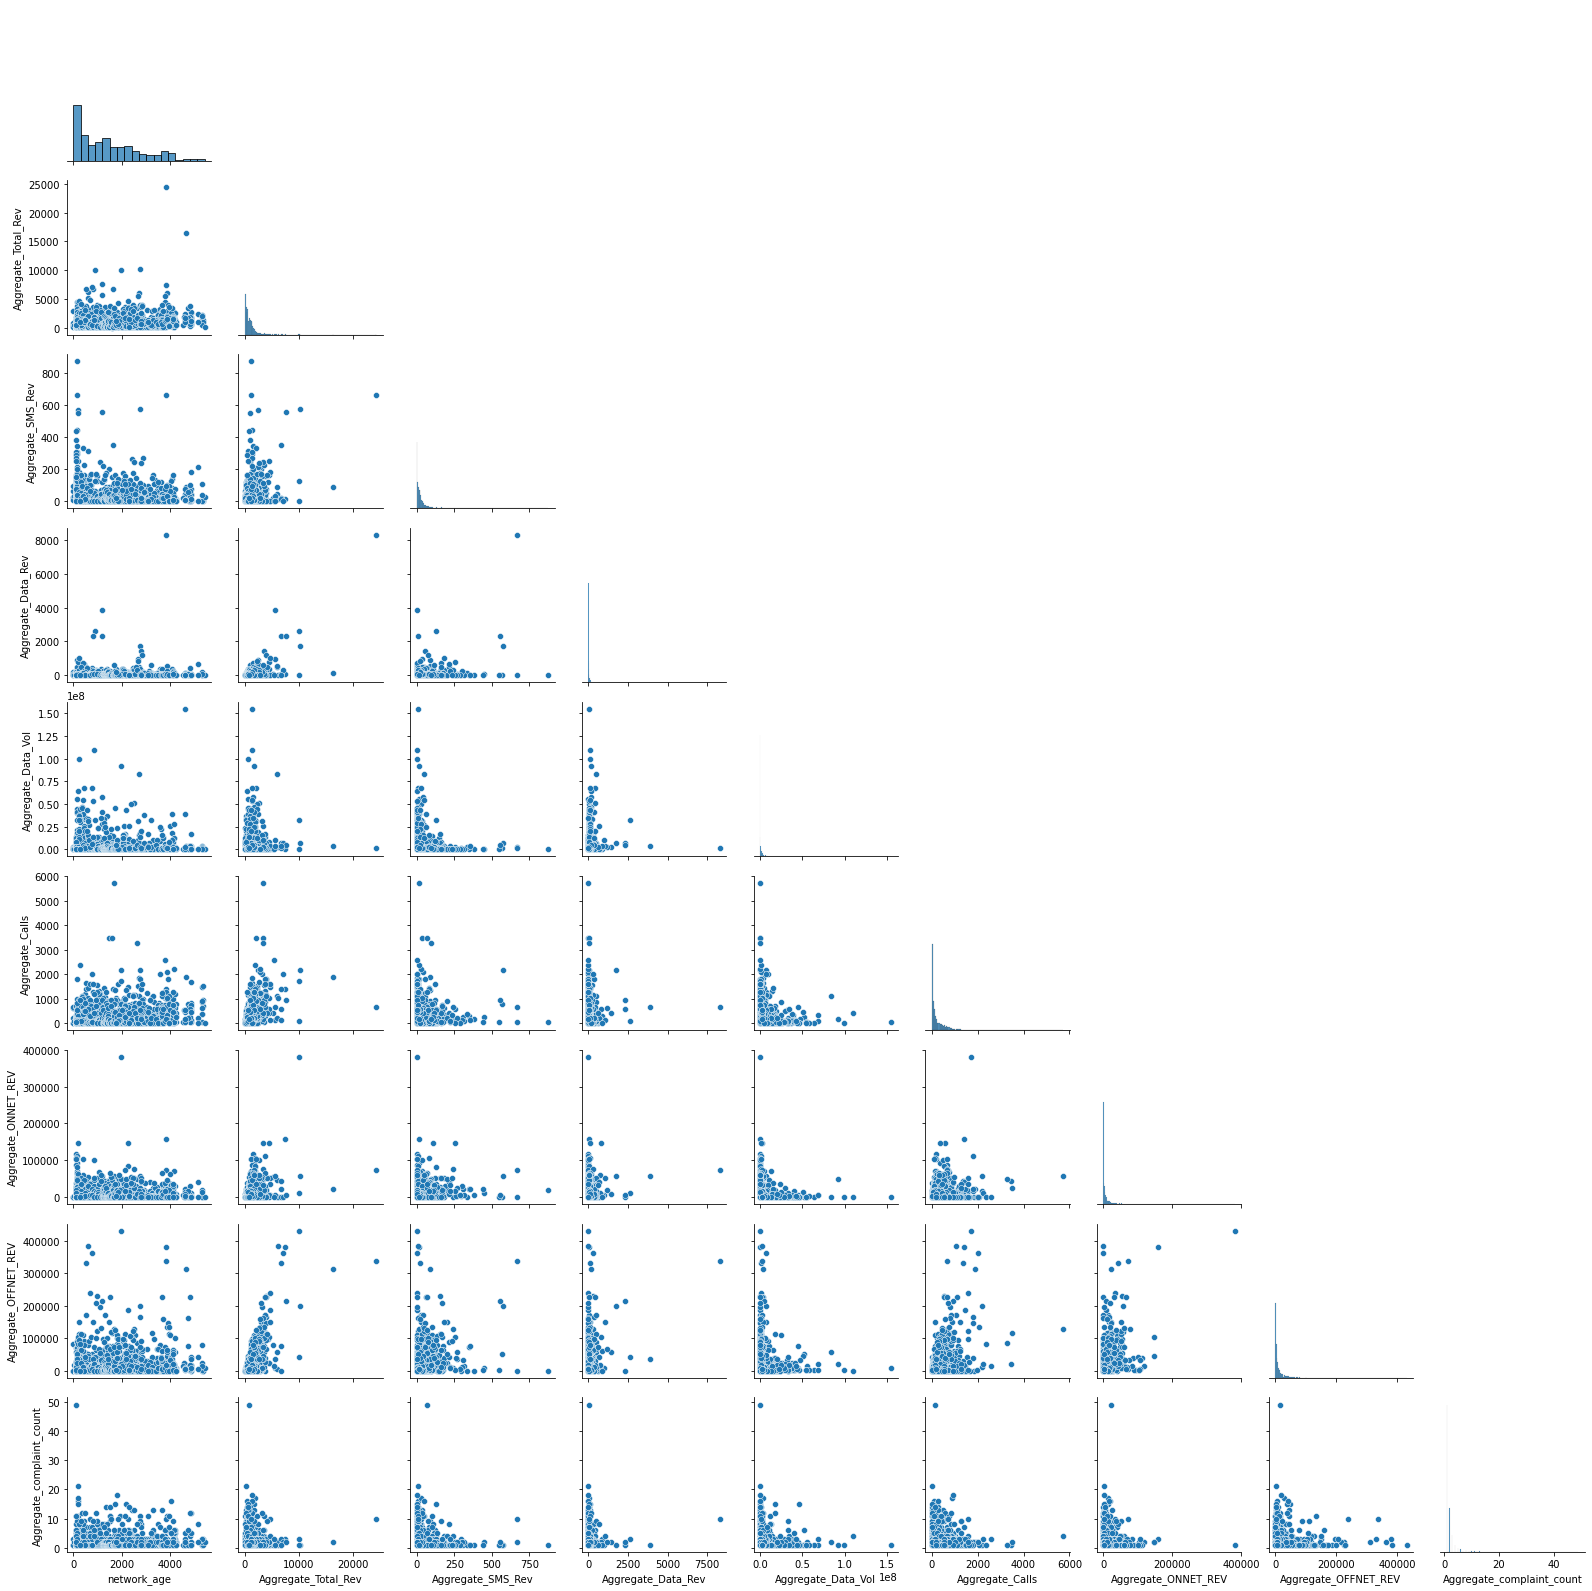

In [ ]:
# pairplot
sns.pairplot(df_churn, corner=True)

In [ ]:
# Checking for missing values and duplicate records
missing_duplicates(df_churn)

There are missing values in the dataset
There are 245 missing values in the feature:  aug_user_type
Percentage of missing values in the feature: 12.25 %
Percentage of missing values in total data points: 0.875 %
There are 206 missing values in the feature:  sep_user_type
Percentage of missing values in the feature: 10.3 %
Percentage of missing values in total data points: 0.736 %
There are 1 missing values in the feature:  aug_fav_a
Percentage of missing values in the feature: 0.05 %
Percentage of missing values in total data points: 0.004 %
There are 1 missing values in the feature:  sep_fav_a
Percentage of missing values in the feature: 0.05 %
Percentage of missing values in total data points: 0.004 %
There are no duplicate records found in the dataset


In [ ]:
# replacing missing values with mode
df_churn['aug_user_type'].fillna(df_churn['aug_user_type'].mode()[0], inplace=True )
df_churn['sep_user_type'].fillna(df_churn['sep_user_type'].mode()[0], inplace=True )
df_churn['aug_fav_a'].fillna(df_churn['aug_fav_a'].mode()[0], inplace=True )
df_churn['sep_fav_a'].fillna(df_churn['sep_fav_a'].mode()[0], inplace=True )

In [ ]:
# Checking for missing values and duplicate records after treating missing values
missing_duplicates(df_churn)

There are no missing values in the dataset
There are no duplicate records found in the dataset


In [ ]:
# Getting column names
df_churn.columns

Index(['network_age', 'Aggregate_Total_Rev', 'Aggregate_SMS_Rev',
       'Aggregate_Data_Rev', 'Aggregate_Data_Vol', 'Aggregate_Calls',
       'Aggregate_ONNET_REV', 'Aggregate_OFFNET_REV',
       'Aggregate_complaint_count', 'aug_user_type', 'sep_user_type',
       'aug_fav_a', 'sep_fav_a', 'Class'],
      dtype='object')

In [ ]:
# We will perform one hot encoding on all categorical variables.
# Drop_first is set to True in order to avoid multicolinearity and also it reduces number of features
# We will not encode the target variable i.e 'Class'
df_churn = pd.get_dummies(data=df_churn, columns=['aug_user_type','sep_user_type','aug_fav_a','sep_fav_a'], drop_first=True)
df_churn.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,Class,aug_user_type_3G,aug_user_type_Other,sep_user_type_3G,sep_user_type_Other,aug_fav_a_mobilink,aug_fav_a_ptcl,aug_fav_a_telenor,aug_fav_a_ufone,aug_fav_a_warid,aug_fav_a_zong,sep_fav_a_ptcl,sep_fav_a_telenor,sep_fav_a_ufone,sep_fav_a_warid,sep_fav_a_zong
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,Churned,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,Churned,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Churned,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,Active,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,Active,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_churn.shape

(2000, 25)

In [ ]:
# Function to create data imbalance for minority class
def create_imbalance1(df,target_index,Perc):
    data = df.copy()
    
    # seperating independent and dependent variables
    X = data.drop(data.columns[target_index],axis=1)
    y = data.iloc[:,target_index]
    
    # creating imbalance from given percentage
    ratio1 = int(y.value_counts().sort_values(ascending=False)[1] * (Perc/100))
    ratio2 = int(y.value_counts().sort_values(ascending=False)[1]) - ratio1
    label1 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[1]
    label2 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[0]
    
    #making imbalance
    X_res, y_res = make_imbalance(X, y, sampling_strategy={label1:ratio1, label2:ratio2}, random_state=1)
    target_variable = data.columns[target_index]
    X_res[target_variable] = y_res
    
    return X_res

Balance ratio of variable in Percentage
Active     65.0
Churned    35.0
Name: Class, dtype: float64



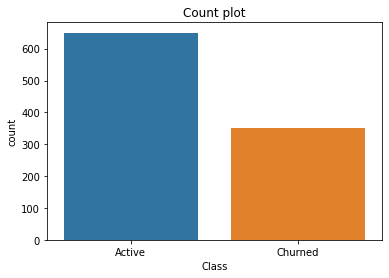

In [ ]:
# creating 65:35 imbalance ratio
df_churn_65 = create_imbalance1(df_churn,9,65)
balance_ratio(df_churn_65['Class'])

Balance ratio of variable in Percentage
Active     75.0
Churned    25.0
Name: Class, dtype: float64



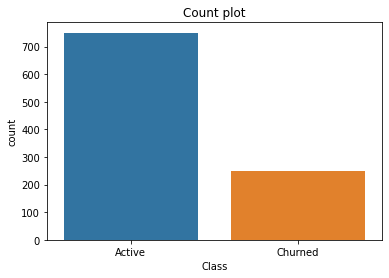

In [ ]:
# creating 75:25 imbalance ratio
df_churn_75 = create_imbalance1(df_churn,9,75)
balance_ratio(df_churn_75['Class'])

Balance ratio of variable in Percentage
Active     90.0
Churned    10.0
Name: Class, dtype: float64



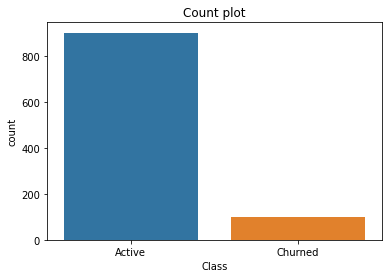

In [ ]:
# creating 90:10 imbalance ratio
df_churn_90 = create_imbalance1(df_churn,9,90)
balance_ratio(df_churn_90['Class'])

**Base line Model**

In [ ]:
# grid search to find best hyper tuning parameters

# configuring min max sacling
scale_minmax = MinMaxScaler()

# seperating target and features
X = df_churn.drop(columns=['Class'],axis=1)
y = df_churn['Class']

X = pd.DataFrame(scale_minmax.fit_transform(X), columns=X.columns)


grid = {
    'max_features': [4,5],
    'max_depth': [4,5,6],
    'min_samples_leaf': [20,40], 
    'min_samples_split': [2,4,6],
       }

RF_Model = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = RF_Model, param_grid = grid, cv = 10,n_jobs=-1,scoring='f1')
grid_search.fit(X, y)
print(grid_search.best_params_,'\n')

{'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 20, 'min_samples_split': 2} 



In [ ]:
# configuring stratified cross validation with cv=10
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# configuring scaling
scale = MinMaxScaler()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.73782 +/- 0.00707
Test F1 score after 10 fold CV: 0.71142 +/- 0.03787
Train kappa after 10 fold CV: 0.49378 +/- 0.01335
Test Kappa after 10 fold CV: 0.444 +/- 0.06312
Train Accuracy after 10 fold CV: 0.74689 +/- 0.00668
Test Accuracy after 10 fold CV: 0.722 +/- 0.03156



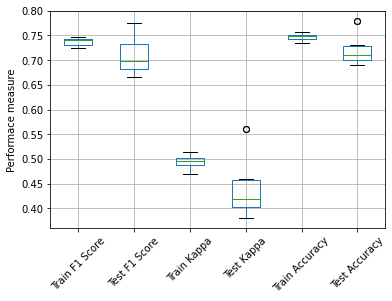

In [ ]:
# for original data

# seperating target and features
X = df_churn.drop(columns=['Class'],axis=1)
y = df_churn['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=20, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='Churned')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='Churned')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_original = train_acc
test_acc_BL_original = test_acc
train_f1_BL_original = train_f1
test_f1_BL_original = test_f1
train_kappa_BL_original = train_kappa
test_kappa_BL_original = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.58039 +/- 0.02395
Test F1 score after 10 fold CV: 0.51329 +/- 0.09136
Train kappa after 10 fold CV: 0.43765 +/- 0.02614
Test Kappa after 10 fold CV: 0.3621 +/- 0.1002
Train Accuracy after 10 fold CV: 0.76956 +/- 0.00907
Test Accuracy after 10 fold CV: 0.742 +/- 0.03572



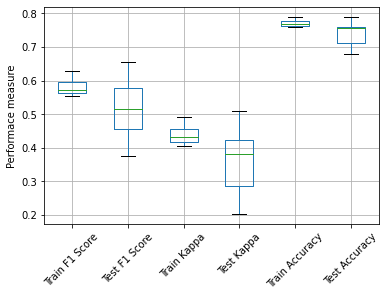

In [ ]:
# for low imbalance data

# seperating target and features
X = df_churn_65.drop(columns=['Class'],axis=1)
y = df_churn_65['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=20, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='Churned')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='Churned')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_low = train_acc
test_acc_BL_low = test_acc
train_f1_BL_low = train_f1
test_f1_BL_low = test_f1
train_kappa_BL_low = train_kappa
test_kappa_BL_low = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.39727 +/- 0.02496
Test F1 score after 10 fold CV: 0.34159 +/- 0.08313
Train kappa after 10 fold CV: 0.31871 +/- 0.02357
Test Kappa after 10 fold CV: 0.26045 +/- 0.09023
Train Accuracy after 10 fold CV: 0.80411 +/- 0.00524
Test Accuracy after 10 fold CV: 0.789 +/- 0.02508



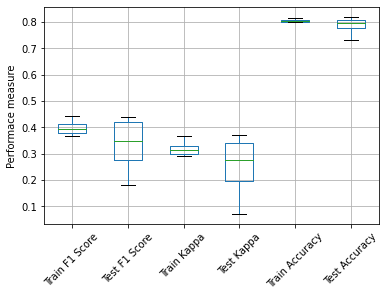

In [ ]:
# for med imbalance data

# seperating target and features
X = df_churn_75.drop(columns=['Class'],axis=1)
y = df_churn_75['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=20, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='Churned')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='Churned')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_med = train_acc
test_acc_BL_med = test_acc
train_f1_BL_med = train_f1
test_f1_BL_med = test_f1
train_kappa_BL_med = train_kappa
test_kappa_BL_med = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.17038 +/- 0.02524
Test F1 score after 10 fold CV: 0.10303 +/- 0.13498
Train kappa after 10 fold CV: 0.15606 +/- 0.02351
Test Kappa after 10 fold CV: 0.0954 +/- 0.12537
Train Accuracy after 10 fold CV: 0.90933 +/- 0.00151
Test Accuracy after 10 fold CV: 0.906 +/- 0.008



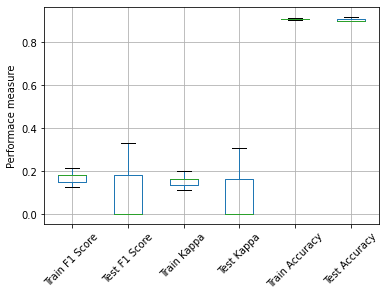

In [ ]:
# for high imbalance data

# seperating target and features
X = df_churn_90.drop(columns=['Class'],axis=1)
y = df_churn_90['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='Churned')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='Churned')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_hig = train_acc
test_acc_BL_hig = test_acc
train_f1_BL_hig = train_f1
test_f1_BL_hig = test_f1
train_kappa_BL_hig = train_kappa
test_kappa_BL_hig = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

**K-means clustering for original data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable
df_churn['Class'] = np.where(df_churn['Class'] == 'Active', 0, df_churn['Class'])
df_churn['Class'] = np.where(df_churn['Class'] == 'Churned', 1, df_churn['Class'])

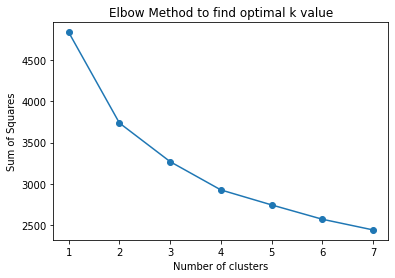

In [ ]:
# checking optimal value of k using elbow method
df_churn_scale = pd.DataFrame(scale_minmax.fit_transform(df_churn), columns=df_churn.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_churn_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


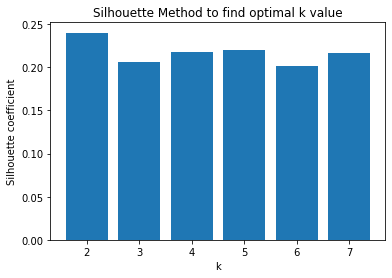

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_churn_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_churn_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_churn['Class'] = np.where(df_churn['Class'] == 0, 'Active', df_churn['Class'])
df_churn['Class'] = np.where(df_churn['Class'] == 1, 'Churned', df_churn['Class'])

In [ ]:
# for original data

# seperating target and features
X = df_churn.drop(columns=['Class'],axis=1)
y = df_churn['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_org = train_f1
test_f1_cluster0_org = test_f1

**********Iteration Number 1**********
Silhouette score: 0.23881
Minority class samples: 646
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 2**********
Silhouette score: 0.23936
Minority class samples: 58
Train F1 0.97427
Test F1 0.75389
**********Iteration Number 3**********
Silhouette score: 0.23893
Minority class samples: 59
Train F1 0.97400
Test F1 0.72611
**********Iteration Number 4**********
Silhouette score: 0.23936
Minority class samples: 62
Train F1 0.97266
Test F1 0.73418
**********Iteration Number 5**********
Silhouette score: 0.23933
Minority class samples: 658
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 6**********
Silhouette score: 0.24141
Minority class samples: 639
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 7**********
Silhouette score: 0.2382
Minority class samples: 58
Train F1 0.97418
Test F1 0.76923
**********Iteration Number 8**********
Silhouette score: 0.24092
Minority class samples: 646
Train F1 0.00000
Test F1 0.000

In [ ]:
# for original data

# seperating target and features
X = df_churn.drop(columns=['Class'],axis=1)
y = df_churn['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_org = train_f1
test_f1_cluster1_org = test_f1

**********Iteration Number 1**********
Silhouette score: 0.23881
Minority class samples: 57
Train F1 0.97468
Test F1 0.75776
**********Iteration Number 2**********
Silhouette score: 0.23936
Minority class samples: 644
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.23893
Minority class samples: 636
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 4**********
Silhouette score: 0.23936
Minority class samples: 635
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.23933
Minority class samples: 56
Train F1 0.97487
Test F1 0.79880
**********Iteration Number 6**********
Silhouette score: 0.24141
Minority class samples: 57
Train F1 0.97483
Test F1 0.73016
**********Iteration Number 7**********
Silhouette score: 0.2382
Minority class samples: 648
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 8**********
Silhouette score: 0.24092
Minority class samples: 58
Train F1 0.97422
Test F1 0.761

**K-means clustering for low imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_churn_65['Class'] = np.where(df_churn_65['Class'] == 'Active', 0, df_churn_65['Class'])
df_churn_65['Class'] = np.where(df_churn_65['Class'] == 'Churned', 1, df_churn_65['Class'])

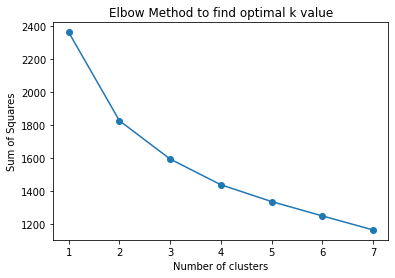

In [ ]:
# checking optimal value of k using elbow method
df_churn_scale = pd.DataFrame(scale_minmax.fit_transform(df_churn_65), columns=df_churn_65.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_churn_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


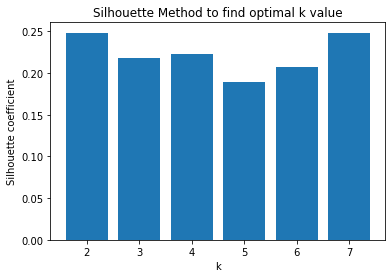

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_churn_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_churn_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_churn_65['Class'] = np.where(df_churn_65['Class'] == 0, 'Active', df_churn_65['Class'])
df_churn_65['Class'] = np.where(df_churn_65['Class'] == 1, 'Churned', df_churn_65['Class'])

In [ ]:
# for low imbalance data

# seperating target and features
X = df_churn_65.drop(columns=['Class'],axis=1)
y = df_churn_65['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_65.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_65.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_low = train_f1
test_f1_cluster0_low = test_f1

**********Iteration Number 1**********
Silhouette score: 0.24476
Minority class samples: 191
Train F1 0.61644
Test F1 0.34615
**********Iteration Number 2**********
Silhouette score: 0.24855
Minority class samples: 195
Train F1 0.60403
Test F1 0.51852
**********Iteration Number 3**********
Silhouette score: 0.24533
Minority class samples: 124
Train F1 0.77828
Test F1 0.55738
**********Iteration Number 4**********
Silhouette score: 0.24644
Minority class samples: 125
Train F1 0.76444
Test F1 0.59016
**********Iteration Number 5**********
Silhouette score: 0.24593
Minority class samples: 192
Train F1 0.62585
Test F1 0.57627
**********Iteration Number 6**********
Silhouette score: 0.24874
Minority class samples: 123
Train F1 0.77209
Test F1 0.67742
**********Iteration Number 7**********
Silhouette score: 0.2462
Minority class samples: 130
Train F1 0.77193
Test F1 0.40000
**********Iteration Number 8**********
Silhouette score: 0.25076
Minority class samples: 192
Train F1 0.60544
Test F1 0

In [ ]:
# for low imbalance data

# seperating target and features
X = df_churn_65.drop(columns=['Class'],axis=1)
y = df_churn_65['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_65.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_65.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_low = train_f1
test_f1_cluster1_low = test_f1

**********Iteration Number 1**********
Silhouette score: 0.24476
Minority class samples: 124
Train F1 0.78947
Test F1 0.40741
**********Iteration Number 2**********
Silhouette score: 0.24855
Minority class samples: 120
Train F1 0.74510
Test F1 0.51852
**********Iteration Number 3**********
Silhouette score: 0.24533
Minority class samples: 191
Train F1 0.56115
Test F1 0.42308
**********Iteration Number 4**********
Silhouette score: 0.24644
Minority class samples: 190
Train F1 0.59859
Test F1 0.48148
**********Iteration Number 5**********
Silhouette score: 0.24593
Minority class samples: 123
Train F1 0.73934
Test F1 0.60317
**********Iteration Number 6**********
Silhouette score: 0.24874
Minority class samples: 192
Train F1 0.56631
Test F1 0.57692
**********Iteration Number 7**********
Silhouette score: 0.2462
Minority class samples: 185
Train F1 0.56506
Test F1 0.35556
**********Iteration Number 8**********
Silhouette score: 0.25076
Minority class samples: 123
Train F1 0.74178
Test F1 0

**K-means clustering for med imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_churn_75['Class'] = np.where(df_churn_75['Class'] == 'Active', 0, df_churn_75['Class'])
df_churn_75['Class'] = np.where(df_churn_75['Class'] == 'Churned', 1, df_churn_75['Class'])

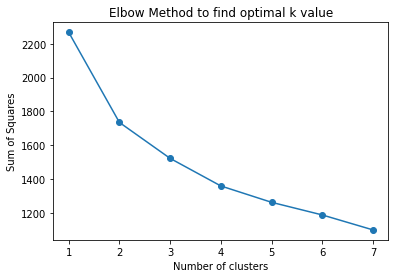

In [ ]:
# checking optimal value of k using elbow method
df_churn_scale = pd.DataFrame(scale_minmax.fit_transform(df_churn_75), columns=df_churn_75.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_churn_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


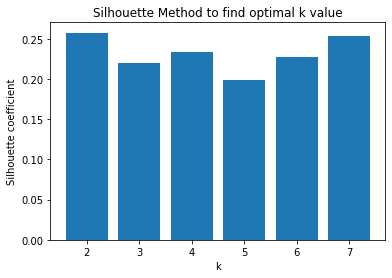

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_churn_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_churn_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_churn_75['Class'] = np.where(df_churn_75['Class'] == 0, 'Active', df_churn_75['Class'])
df_churn_75['Class'] = np.where(df_churn_75['Class'] == 1, 'Churned', df_churn_75['Class'])

In [ ]:
# for med imbalance data

# seperating target and features
X = df_churn_75.drop(columns=['Class'],axis=1)
y = df_churn_75['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_75.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_75.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_med = train_f1
test_f1_cluster0_med = test_f1

**********Iteration Number 1**********
Silhouette score: 0.25786
Minority class samples: 134
Train F1 0.50549
Test F1 0.20000
**********Iteration Number 2**********
Silhouette score: 0.25945
Minority class samples: 138
Train F1 0.40462
Test F1 0.30303
**********Iteration Number 3**********
Silhouette score: 0.25704
Minority class samples: 85
Train F1 0.68702
Test F1 0.28571
**********Iteration Number 4**********
Silhouette score: 0.25696
Minority class samples: 87
Train F1 0.64662
Test F1 0.34286
**********Iteration Number 5**********
Silhouette score: 0.25712
Minority class samples: 92
Train F1 0.64789
Test F1 0.42424
**********Iteration Number 6**********
Silhouette score: 0.254
Minority class samples: 141
Train F1 0.36047
Test F1 0.32258
**********Iteration Number 7**********
Silhouette score: 0.25562
Minority class samples: 88
Train F1 0.66667
Test F1 0.34286
**********Iteration Number 8**********
Silhouette score: 0.25601
Minority class samples: 89
Train F1 0.62595
Test F1 0.51429

In [ ]:
# for med imbalance data

# seperating target and features
X = df_churn_75.drop(columns=['Class'],axis=1)
y = df_churn_75['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_75.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_75.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_med = train_f1
test_f1_cluster1_med = test_f1

**********Iteration Number 1**********
Silhouette score: 0.25786
Minority class samples: 91
Train F1 0.68493
Test F1 0.24390
**********Iteration Number 2**********
Silhouette score: 0.25945
Minority class samples: 87
Train F1 0.60317
Test F1 0.45714
**********Iteration Number 3**********
Silhouette score: 0.25704
Minority class samples: 140
Train F1 0.45055
Test F1 0.25806
**********Iteration Number 4**********
Silhouette score: 0.25696
Minority class samples: 138
Train F1 0.35503
Test F1 0.32258
**********Iteration Number 5**********
Silhouette score: 0.25712
Minority class samples: 133
Train F1 0.39521
Test F1 0.20690
**********Iteration Number 6**********
Silhouette score: 0.254
Minority class samples: 84
Train F1 0.62903
Test F1 0.50000
**********Iteration Number 7**********
Silhouette score: 0.25562
Minority class samples: 137
Train F1 0.44318
Test F1 0.26667
**********Iteration Number 8**********
Silhouette score: 0.25601
Minority class samples: 136
Train F1 0.42529
Test F1 0.411

**K-means clustering for high imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_churn_90['Class'] = np.where(df_churn_90['Class'] == 'Active', 0, df_churn_90['Class'])
df_churn_90['Class'] = np.where(df_churn_90['Class'] == 'Churned', 1, df_churn_90['Class'])

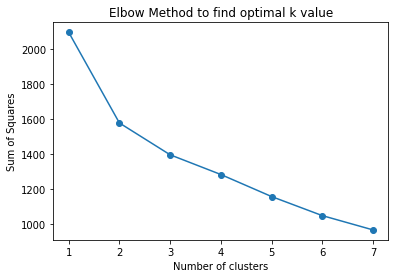

In [ ]:
# checking optimal value of k using elbow method
df_churn_scale = pd.DataFrame(scale_minmax.fit_transform(df_churn_90), columns=df_churn_90.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_churn_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


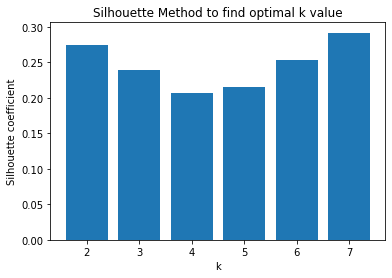

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_churn_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_churn_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_churn_90['Class'] = np.where(df_churn_90['Class'] == 0, 'Active', df_churn_90['Class'])
df_churn_90['Class'] = np.where(df_churn_90['Class'] == 1, 'Churned', df_churn_90['Class'])

In [ ]:
# for high imbalance data

# seperating target and features
X = df_churn_90.drop(columns=['Class'],axis=1)
y = df_churn_90['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_90.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_90.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_hig = train_f1
test_f1_cluster0_hig = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27053
Minority class samples: 34
Train F1 0.41860
Test F1 0.00000
**********Iteration Number 2**********
Silhouette score: 0.27396
Minority class samples: 36
Train F1 0.40000
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27666
Minority class samples: 35
Train F1 0.37209
Test F1 0.00000
**********Iteration Number 4**********
Silhouette score: 0.27144
Minority class samples: 33
Train F1 0.39024
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.27603
Minority class samples: 34
Train F1 0.34146
Test F1 0.16667
**********Iteration Number 6**********
Silhouette score: 0.27452
Minority class samples: 34
Train F1 0.34146
Test F1 0.00000
**********Iteration Number 7**********
Silhouette score: 0.27488
Minority class samples: 33
Train F1 0.35000
Test F1 0.00000
**********Iteration Number 8**********
Silhouette score: 0.27611
Minority class samples: 55
Train F1 0.25397
Test F1 0.00000


In [ ]:
# for high imbalance data

# seperating target and features
X = df_churn_90.drop(columns=['Class'],axis=1)
y = df_churn_90['Class']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['Class'] = y_test_fold 
  df_train['Class'] = y_train_fold
  df_train['Class'] = np.where(df_train['Class'] == 'Active', 0, df_train['Class'])
  df_train['Class'] = np.where(df_train['Class'] == 'Churned', 1, df_train['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Active', 0, test_data['Class'])
  test_data['Class'] = np.where(test_data['Class'] == 'Churned', 1, test_data['Class'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_churn_90.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_churn_cluster = df_train_scale.copy()
  df_churn_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_churn_cluster[df_churn_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.Class.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['Class'], axis=1)
    labels = df_cluster0['Class']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_churn_90.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['Class'], axis=1)
    y_test = test_data_scale['Class']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=1)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_hig = train_f1
test_f1_cluster1_hig = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27053
Minority class samples: 56
Train F1 0.25000
Test F1 0.00000
**********Iteration Number 2**********
Silhouette score: 0.27396
Minority class samples: 54
Train F1 0.22951
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27666
Minority class samples: 55
Train F1 0.25397
Test F1 0.00000
**********Iteration Number 4**********
Silhouette score: 0.27144
Minority class samples: 57
Train F1 0.24615
Test F1 0.18182
**********Iteration Number 5**********
Silhouette score: 0.27603
Minority class samples: 56
Train F1 0.19355
Test F1 0.16667
**********Iteration Number 6**********
Silhouette score: 0.27452
Minority class samples: 56
Train F1 0.22222
Test F1 0.00000
**********Iteration Number 7**********
Silhouette score: 0.27488
Minority class samples: 57
Train F1 0.19048
Test F1 0.33333
**********Iteration Number 8**********
Silhouette score: 0.27611
Minority class samples: 35
Train F1 0.40909
Test F1 0.00000


**Comparison using permutation test**

In [ ]:
from numpy.random.mtrand import permutation
def get_pvalue(iterations,Results1,Results2,diff):
  concat = np.concatenate((Results1,Results2))
  count = 0
  for i in range(0,iterations):
    permutation = np.random.permutation(concat)
    p_current = permutation[:len(Results1)]
    p_new = permutation[len(Results1):]
    mean_permutation_current = p_current.mean()
    mean_permutation_new = p_new.mean()
    t_permutation = mean_permutation_new - mean_permutation_current

    if(t_permutation > diff):
      count += 1
  p_value = count / iterations
  if p_value > 0.05:
    print('Since p value {} is greater than 0.05 we failed to reject null hypothesis'.format(round(p_value,4)))
    #print('Results 1 are not better than Results 2')
  else:
    print('Since p value {} is less than 0.05 we will reject null hypothesis'.format(round(p_value,4)))
    #print('Results 1 are better than Results 2')
  return #p_value

In [ ]:
diff1 = test_f1_cluster0_org.mean() - test_f1_BL_original.mean()
get_pvalue(30000, test_f1_cluster0_org, test_f1_BL_original, diff1)

Since p value 0.9844 is greater than 0.05 we failed to reject null hypothesis


In [ ]:
diff1 = test_f1_BL_original.mean() - test_f1_cluster1_org.mean()
get_pvalue(30000, test_f1_BL_original, test_f1_cluster1_org, diff1)

Since p value 0.0165 is less than 0.05 we will reject null hypothesis


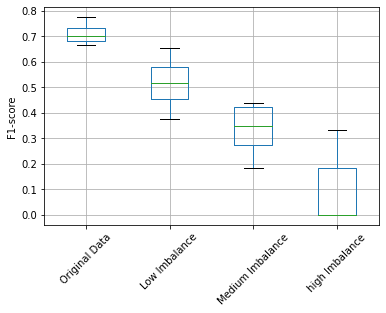

In [ ]:
# comaprison of baseline model for different imbalances
comparison = pd.concat([pd.Series(test_f1_BL_original), pd.Series(test_f1_BL_low), pd.Series(test_f1_BL_med), pd.Series(test_f1_BL_hig)], axis=1)
comparison.columns = ['Original Data', 'Low Imbalance', 'Medium Imbalance', 'high Imbalance']
comparison.boxplot()
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.show()


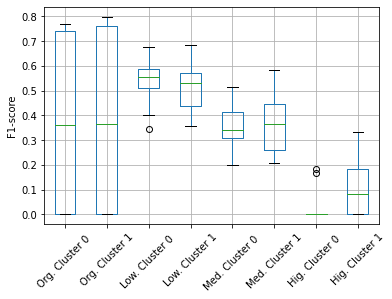

In [ ]:
# comaprison of custom model for different imbalances
comparison1 = pd.concat([pd.Series(test_f1_cluster0_org), pd.Series(test_f1_cluster1_org), pd.Series(test_f1_cluster0_low), pd.Series(test_f1_cluster1_low), pd.Series(test_f1_cluster0_med), pd.Series(test_f1_cluster1_med), pd.Series(test_f1_cluster0_hig), pd.Series(test_f1_cluster1_hig)], axis=1)
comparison1.columns = ['Org. Cluster 0 ', 'Org. Cluster 1', 'Low. Cluster 0 ', 'Low. Cluster 1', 'Med. Cluster 0 ', 'Med. Cluster 1', 'Hig. Cluster 0 ', 'Hig. Cluster 1']
comparison1.boxplot()
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
comparison

,Original Data,Low Imbalance,Medium Imbalance,high Imbalance
0,0.666667,0.384615,0.181818,0.000000
1,0.680412,0.461538,0.258065,0.000000
2,0.770833,0.452830,0.258065,0.000000
3,0.775510,0.509804,0.424242,0.000000
4,0.684492,0.586207,0.322581,0.333333
5,0.713568,0.631579,0.411765,0.000000
6,0.673913,0.375000,0.322581,0.333333
7,0.735294,0.555556,0.437500,0.000000
8,0.729064,0.520000,0.375000,0.181818
9,0.684492,0.655738,0.424242,0.181818


In [ ]:
comparison1

,Org. Cluster 0,Org. Cluster 1,Low. Cluster 0,Low. Cluster 1,Med. Cluster 0,Med. Cluster 1,Hig. Cluster 0,Hig. Cluster 1
0,0.000000,0.757764,0.346154,0.407407,0.200000,0.243902,0.000000,0.000000
1,0.753894,0.000000,0.518519,0.518519,0.303030,0.457143,0.000000,0.000000
2,0.726115,0.000000,0.557377,0.423077,0.285714,0.258065,0.000000,0.000000
3,0.734177,0.000000,0.590164,0.481481,0.342857,0.322581,0.000000,0.181818
4,0.000000,0.798799,0.576271,0.603175,0.424242,0.206897,0.166667,0.166667
5,0.000000,0.730159,0.677419,0.576923,0.322581,0.500000,0.000000,0.000000
6,0.769231,0.000000,0.400000,0.355556,0.342857,0.266667,0.000000,0.333333
7,0.000000,0.761610,0.509804,0.545455,0.514286,0.411765,0.000000,0.000000
8,0.000000,0.791541,0.555556,0.560000,0.470588,0.585366,0.181818,0.333333
9,0.746082,0.000000,0.622951,0.686567,0.388889,0.411765,0.000000,0.181818


**Comparison between base and custom models**

In [ ]:
# original data comparison base line Vs custo model
diff = test_f1_BL_original.mean() - test_f1_cluster0_org.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_original, test_f1_cluster0_org, diff)

diff = test_f1_BL_original.mean() - test_f1_cluster1_org.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_original, test_f1_cluster1_org, diff)

Since p value 0.014 is less than 0.05 we will reject null hypothesis
Since p value 0.0157 is less than 0.05 we will reject null hypothesis


In [ ]:
# low data imbalance comparison base line Vs custo model
diff = test_f1_BL_low.mean() - test_f1_cluster0_low.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_low, test_f1_cluster0_low, diff)

diff = test_f1_BL_low.mean() - test_f1_cluster1_low.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_low, test_f1_cluster1_low, diff)

Since p value 0.6908 is greater than 0.05 we failed to reject null hypothesis
Since p value 0.5203 is greater than 0.05 we failed to reject null hypothesis


In [ ]:
# Medium data imbalance comparison base line Vs custo model
diff = test_f1_BL_med.mean() - test_f1_cluster0_med.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_med, test_f1_cluster0_med, diff)

diff = test_f1_BL_med.mean() - test_f1_cluster1_med.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_med, test_f1_cluster1_med, diff)

Since p value 0.669 is greater than 0.05 we failed to reject null hypothesis
Since p value 0.6951 is greater than 0.05 we failed to reject null hypothesis


In [ ]:
# High data imbalance comparison base line Vs custo model
diff = test_f1_BL_hig.mean() - test_f1_cluster0_hig.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_hig, test_f1_cluster0_hig, diff)

diff = test_f1_BL_hig.mean() - test_f1_cluster1_hig.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_hig, test_f1_cluster1_hig, diff)

Since p value 0.0735 is greater than 0.05 we failed to reject null hypothesis
Since p value 0.5546 is greater than 0.05 we failed to reject null hypothesis
